# Specific Heat Capacity from pycalphad

In this notebook, the interaction between PyRolL and pycalphad is demonstrated. 
In this example, the calphad method is used to calculate the specific heat capacity of the low-carbon steel C15 (1.0401) using free `tdb` databases provided by [MatCalc Engineering GmbH](https://www.matcalc.at/index.php/databases/open-databases). The measured chemical composition (wt%) of a example can be seen in the following table: 

| Steel grade  | C    | Si   | Mn   | Cr   | Ni   | Cu   | P     | S      | Fe    |
|--------------|------|------|------|------|------|------|-------|--------|-------|
| C15 (1.0401) | 0.16 | 0.16 | 0.69 | 0.12 | 0.09 | 0.17 | 0.002 | 0.0065 | 98.43 |

Further, thermodynamical database files (`tdb`) for other alloying systems can be found [here](https://avdwgroup.engin.brown.edu/). The specific-heat-capacity is mostly important when considering cooling processes which often follow a hot rolling process. As always, we first import the necessary python modules.

In [1]:
import numpy as np
import pyroll.core as pr
import matplotlib.pyplot as plt
import pycalphad.variables as v
import scipy.interpolate as interpolate


from pycalphad import Database
from scipy.integrate import quad
from pycalphad import equilibrium
from pyroll.freiberg_flow_stress import FreibergFlowStressCoefficients

Loading of the thermodynamic database from file. A warning here regarding a type definition character is to be expected and no error.

In [2]:
database = Database('mc_fe_v2.059.pycalphad.tdb')

/home/christoph/.local/share/virtualenvs/pyroll-examples-YS1GospC/lib/python3.11/site-packages/pycalphad/io/tdb.py:929: UserWarning: The type definition character `%` was defined in the following phases: ['LIQUID', 'FCC_A1', 'BCC_A2', 'H_BCC', 'BCC_DISL', 'HCP_A3', 'ALPHA_MN', 'BETA_MN', 'BETA_RHOMBO_B', 'DIAMOND_A4', 'GRAPHITE', 'BCC_B2', 'CHI_A12', 'CO3MO', 'CO3V', 'COV3', 'CR3MN5', 'G_PHASE', 'LAVES_PHASE', 'MNNI', 'MNNI2', 'MNNI_T3', 'MU_PHASE', 'MU_PHASE_I', 'ETA', 'NITI2', 'PI_PHASE', 'R_PHASE', 'SIGMA', 'FE17Y2', 'NI5Y', 'PDFE_L12', 'PDMN_AF', 'PDMN_P', 'PDMN_B2', 'PD2MN', 'PD3MN', 'PD5MN3', 'PD6FE5MN2', 'CEMENTITE', 'CR2VC2', 'K_CARB', 'KSI_CARBIDE', 'M3C2', 'M6C', 'M7C3', 'M12C', 'M23C6', 'MOC_ETA', 'V3C2', 'WC', 'EPS_CARB', 'ETA_CARB', 'FE24C10', 'KSI_FE5C2', 'ALN', 'ALN_EQU', 'BN_HP4', 'CR3NI2SIN', 'FE4N', 'MN6N4', 'MN6N5', 'MNSIN2', 'SI3N4', 'ZET', 'CRB', 'CR2B', 'CR5B3', 'FEB', 'FENBB', 'FE3NB3B4', 'M2B', 'MNB2', 'MNB4', 'O_MN2B', 'MN3B4', 'MOB', 'MOB2', 'MO2M1B2', 'NBB', 

## Conversion of weight-fractions to molar-fractions
The industrial standard, how to provide the chemical composition of an alloy is to use weight-fractions. In the scientific realm, however, molar-fractions are more common. Therefore, we need a function which converts weight-fractions to molar fractions. This can be handled by the `get_mole_fractions` function of `pycalphad`. Further, one needs to calculate the total molar mass of the alloy. Therefore, a dict with the respective molar masses of each atom is defined.

In [3]:
molar_masses_grams_per_mol = {
    'H': 1.008, 'HE': 4.0026, 'LI': 6.94, 'BE': 9.0122, 'B': 10.81,
    'C': 12.011, 'N': 14.007, 'O': 15.999, 'F': 18.998, 'NE': 20.180,
    'NA': 22.990, 'MG': 24.305, 'AL': 26.982, 'SI': 28.085, 'P': 30.974,
    'S': 32.06, 'CL': 35.45, 'AR': 39.948, 'K': 39.098, 'CA': 40.078,
    'SC': 44.956, 'TI': 47.867, 'V': 50.942, 'CR': 51.996, 'MN': 54.938,
    'FE': 55.845, 'CO': 58.933, 'NI': 58.693, 'CU': 63.546, 'ZN': 65.38,
    'GA': 69.723, 'GE': 72.63, 'AS': 74.922, 'SE': 78.971, 'BR': 79.904,
    'KR': 83.798, 'RB': 85.468, 'SR': 87.62, 'Y': 88.906, 'ZR': 91.224,
    'NB': 92.906, 'MO': 95.95, 'TC': 98.0, 'RU': 101.07, 'RH': 102.91,
    'PD': 106.42, 'AG': 107.87, 'CD': 112.41, 'IN': 114.82, 'SN': 118.71,
    'SB': 121.76, 'TE': 127.6, 'I': 126.9, 'XE': 131.29, 'CS': 132.91,
    'BA': 137.33, 'LA': 138.91, 'CE': 140.12, 'PR': 140.91, 'ND': 144.24,
    'PM': 145.0, 'SM': 150.36, 'EU': 151.96, 'GD': 157.25, 'TB': 158.93,
    'DY': 162.5, 'HO': 164.93, 'ER': 167.26, 'TM': 168.93, 'YB': 173.05,
    'LU': 174.97, 'HF': 178.49, 'TA': 180.95, 'W': 183.84, 'RE': 186.21,
    'OS': 190.23, 'IR': 192.22, 'PT': 195.08, 'AU': 196.97, 'HG': 200.59,
    'TL': 204.38, 'PB': 207.2, 'BI': 208.98, 'PO': 209.0, 'AT': 210.0,
    'RN': 222.0, 'FR': 223.0, 'RA': 226.0, 'AC': 227.0, 'TH': 232.04,
    'PA': 231.04, 'U': 238.03, 'NP': 237.0, 'PU': 244.0, 'AM': 243.0,
    'CM': 247.0, 'BK': 247.0, 'CF': 251.0, 'ES': 252.0, 'FM': 257.0,
    'MD': 258.0, 'NO': 259.0, 'LR': 266.0
}


## Definition of incoming profile
Now let's define a profile and use it to calculate the molar fractions as well as the molar mass.

In [4]:
profile = pr.Profile.round(
    diameter=50e-3,
    temperature=1200 + 273.15,
    material=["steel", "C15"],
    density=7.5e3,
    strain=0,
    chemical_composition={
        "C": 0.16 / 100,
        "SI": 0.16 / 100,
        "MN": 0.69 / 100,
        "CR": 0.12 / 100,
        "NI": 0.09 / 100,
        "CU": 0.17 / 100,
        "P": 0.002 / 100,
        "S": 0.0065/ 100,
        "FE": 98.43 / 100
    },
    freiberg_flow_stress_coefficients=FreibergFlowStressCoefficients(
        a=2098.29 * 1e6,
        m1=-0.00272,
        m2=0.22312,
        m4=0.00003,
        m5=0.00028,
        m7=-0.58508,
        m8=0.000137,
        baseStrain=0.1,
        baseStrainRate=0.1
    )
)

In [5]:
mass_fractions = {
    v.W('C'): profile.chemical_composition['C'],
    v.W('CU'): profile.chemical_composition['CU'],
    v.W('SI'): profile.chemical_composition['SI'],
    v.W('MN'): profile.chemical_composition['MN'],
    v.W('CR'): profile.chemical_composition['CR'],
    v.W('NI'): profile.chemical_composition['NI'],
    v.W('P'): profile.chemical_composition['P'],
    v.W('S'): profile.chemical_composition['S'],
}

mole_fractions = v.get_mole_fractions(mass_fractions=mass_fractions, dependent_species=v.Species('FE'), pure_element_mass_dict=database)
mole_mass = sum(profile.chemical_composition[element] * molar_masses_grams_per_mol[element] for element in profile.chemical_composition.keys())

## Stepped Equilibrium 
Now we have to calculate a stepped equilibrium using the `pycalphad` package. This equilibrium gives us information about the phase compositions of the alloy at various temperatures between a start and a stop temperature. Further information we have to provide to run the calculations is the atmospheric pressure as well as the number of moles we want to consider. Also, we need information about the expected phases. This information can be gained from literature or a phase diagram. In this case we expect the liquid phase (LIQUID), cementite (CEMENTITE), austenite (FCC_A1) as well as ferrite (BCC_A2) regarding the temperature. At last the composition (chemical elements) of the alloy.

In [6]:
start_temperature_kelvin = 20 + 273.15
end_temperature_kelvin = 1400 + 273.15
number_of_moles = 1
atmospheric_pressure = 101325

conditions = {
    v.X('C'): mole_fractions[v.MoleFraction(v.Species('C'))],
    v.X('CU'): mole_fractions[v.MoleFraction(v.Species('CU'))],
    v.X('SI'): mole_fractions[v.MoleFraction(v.Species('SI'))],
    v.X('MN'): mole_fractions[v.MoleFraction(v.Species('MN'))],
    v.X('CR'): mole_fractions[v.MoleFraction(v.Species('CR'))],
    v.X('NI'): mole_fractions[v.MoleFraction(v.Species('NI'))],
    v.X('P'): mole_fractions[v.MoleFraction(v.Species('P'))],
    v.X('S'): mole_fractions[v.MoleFraction(v.Species('S'))],
    v.N: number_of_moles,
    v.P: atmospheric_pressure,
    v.T: (start_temperature_kelvin, end_temperature_kelvin, 10)  # temperature (start, stop, step)
}
phases = ['LIQUID', 'FCC_A1', 'BCC_A2', 'CEMENTITE']
composition = ['FE', 'C', 'CU', 'SI', 'MN', 'CR', 'NI', 'P', 'S', 'VA']
eq = equilibrium(database, composition, phases, conditions, output=['heat_capacity'])
specific_heat_capacity = (np.squeeze(eq['heat_capacity'].values) / mole_mass) * 1000
temperature = eq['T'].values

## Extracting the specific-heat-capacity 
Now let's inspect the result.
More methods about how to check if the results are valid, can be taken from the pycalphad documentation which can be found [here](https://pycalphad.org/docs/latest/examples/EquilibriumWithOrdering.html).

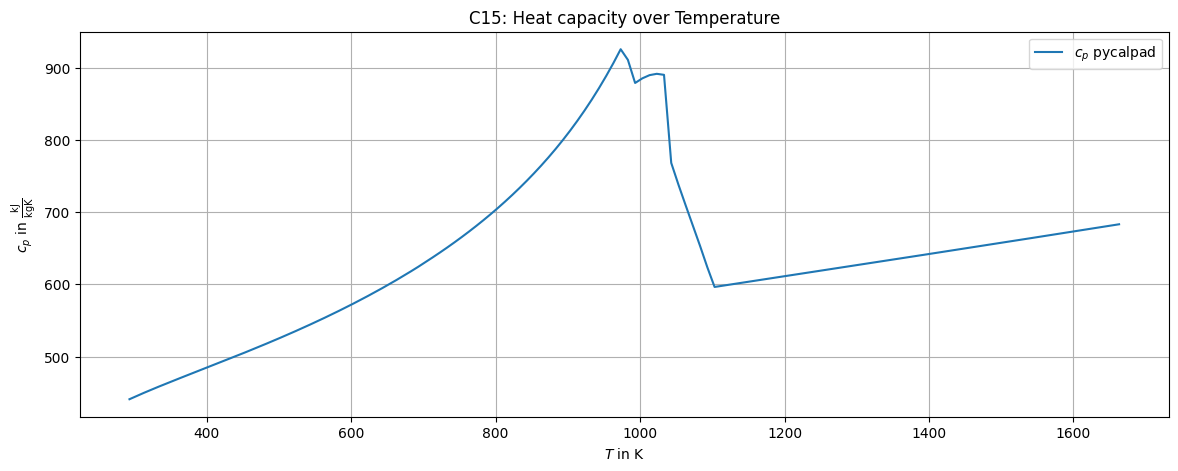

In [19]:
fig: plt.Figure = plt.figure(figsize=(15,5))
ax: plt.Axes = fig.add_subplot()

ax.set_title('C15: Heat capacity over Temperature')
ax.set_xlabel(r"$T$ in $\mathrm{K}$")
ax.set_ylabel(r"$c_{p}$ in $\mathrm{\frac{kJ}{kg K}}$")
ax.grid(True)
ax.set_aspect("equal")
ax.plot(temperature, specific_heat_capacity, label=r'$c_{p}$ pycalpad')
ax.legend()
plt.show()

## Comparison to Data from Spittel et al.
Normally when you set up a PyRolL simulation, we use mean specific heat capacity values. 
A reference for values, is the book "Numerical data and functional relationships in science and technology. Part 1: Metal forming data Ferrous alloys" from Spittel et al.. We will now calculate the mean specific heat capacity values for C15 and compare them with the published values.

/home/christoph/.local/share/virtualenvs/pyroll-examples-YS1GospC/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/christoph/.local/share/virtualenvs/pyroll-examples-YS1GospC/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


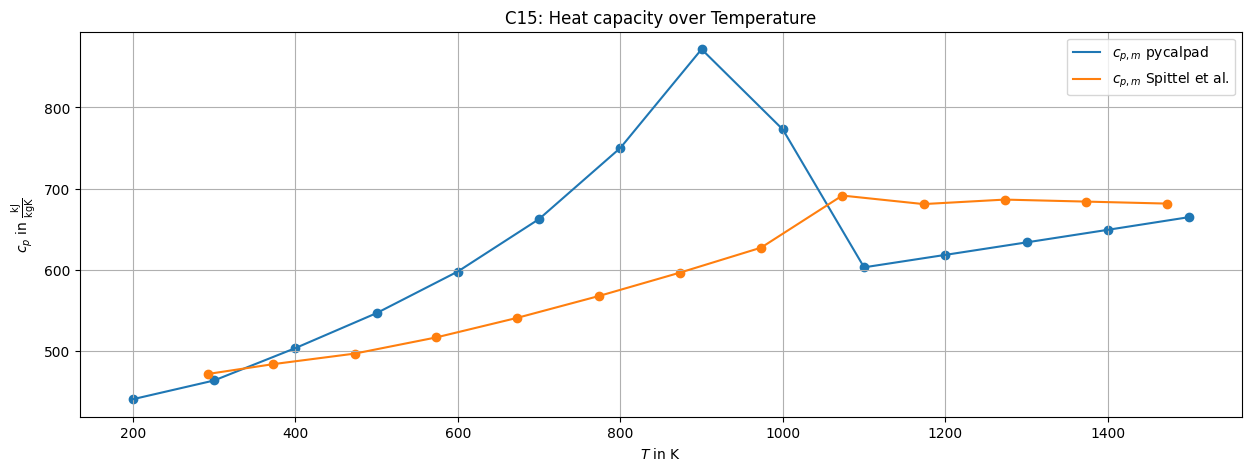

In [20]:
mean_specific_heat_capacity_spittel = np.array(
    [472.11, 484.14, 497.07, 516.92, 541.07, 567.8, 596.65, 627.42, 691.57, 681.08, 686.60, 684.14, 681.68])
temperatures_spittel = np.array([20, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200]) + 273.15

temperature_ranges = np.arange(100, 1600, 100)
np.insert(temperature_ranges, 0, 20)

mean_specific_heat_values = []

for start_temp in temperature_ranges:
    end_temp = start_temp + 100
    indices = np.where((temperature >= start_temp) & (temperature < end_temp))
    mean_specific_heat = np.mean(specific_heat_capacity[indices])
    mean_specific_heat_values.append(mean_specific_heat)

mean_specific_heat_values = np.array(mean_specific_heat_values)

fig: plt.Figure = plt.figure(figsize=(15,5))
ax: plt.Axes = fig.add_subplot()

ax.set_title('C15: Heat capacity over Temperature')
ax.set_xlabel(r"$T$ in $\mathrm{K}$")
ax.set_ylabel(r"$c_{p}$ in $\mathrm{\frac{kJ}{kg K}}$")
ax.grid(True)
ax.set_aspect("equal")
ax.plot(temperature_ranges, mean_specific_heat_values, label=r'$c_{p,m}$ pycalpad')
ax.scatter(temperature_ranges, mean_specific_heat_values, c='C0')
ax.plot(temperatures_spittel, mean_specific_heat_capacity_spittel, label=r'$c_{p,m}$ Spittel et al.')
ax.scatter(temperatures_spittel, mean_specific_heat_capacity_spittel, c='C1')
ax.legend()
plt.show()

## Difference between the data
One can clearly see the advantage of the gained specific heat capacity values. As Spittel et al. published mean specific heat capacity values witch where calculated using a model of Livschitz, `pycalphad` calculates the actual specific heat capacity values. The double peak at around 1000 K arises due to the curie temperature being passed and later the phase change from austenite to ferrite taking place. So one can finally state that when just taking into account the hot forming process, usage of mean specific heat transfer values yields a limited error. When analysing "warm" rolling processes or cooling processes, usage of the specific heat capacity is more accurate than a mean value.

## Usage in PyRolL
To use the specific heat capacity, we will interpolate the function and provide it as a hook for the profile.

In [18]:
specific_heat_capacity_function = interpolate.interp1d(temperature, specific_heat_capacity)

@pr.Profile.specific_heat_capacity
def heat_capacity_interpolated(self: pr.Profile):
    return specific_heat_capacity_function(self.temperature)

sequence = pr.PassSequence([
    pr.RollPass(
        label="K 02/001 - 1",
        roll=pr.Roll(
            groove=pr.SwedishOvalGroove(
                r1=6e-3,
                r2=26e-3,
                ground_width=38e-3,
                usable_width=60e-3,
                depth=7.25e-3
            ),
            nominal_radius=321e-3 / 2,
            rotational_frequency=0.99,

        ),
        gap=13.5e-3,
        coulomb_friction_coefficient=0.4,
        back_tension=0,
        front_tension=0
    ),
    pr.Transport(
        label="I->II",
        duration=6,
    )
])

sequence.solve(profile)

Profile(
    chemical_composition={'C': 0.0016,
     'SI': 0.0016,
     'MN': 0.0069,
     'CR': 0.0012,
     'NI': 0.0009,
     'CU': 0.0017000000000000001,
     'P': 2e-05,
     'S': 6.5e-05,
     'FE': 0.9843000000000001},
    classifiers={'generic_elongation', 'oval', 'swedish_oval'},
    cross_section=Polygon(
        area=0.0014976631456151905,
        height=0.027999999999999997,
        perimeter=0.1545024092875257,
        width=0.06,
        ),
    density=7500.0,
    freiberg_flow_stress_coefficients=FreibergFlowStressCoefficients(a=2098290000.0, m1=-0.00272, m2=0.22312, m3=0, m4=3e-05, m5=0.00028, m6=0, m7=-0.58508, m8=0.000137, m9=0, baseStrain=0.1, baseStrainRate=0.1),
    length=0.0,
    material=['steel', 'C15'],
    strain=0,
    t=6.0571064266249754,
    temperature=1473.15,
    )